In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

### Model Definitions

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hid_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.layers(x)
    def fit_discriminator(self, x_data, criterion, net_G, optimizer, input_size):
        batch_size, _ = x_data.shape[0], x_data.shape[1]
        x_rand = torch.randn((batch_size, input_size))

        self.zero_grad()

        # Forward pass Discriminator on "real" data
        labels_real = torch.ones((batch_size, 1))
        outputs = self.forward(x_data)
        loss_d_real = criterion(outputs, labels_real)

        # Forward pass Discriminator with "fake" data from Generator
        g = net_G(x_rand).detach() # Stop gradients from being updated in generator
        labels_fk = torch.zeros((batch_size, 1))
        outputs = self.forward(g)
        loss_d_fake = criterion(outputs, labels_fk)

        loss_d = loss_d_fake + loss_d_real
        loss_d.backward() # Compute Gradients
        optimizer.step() # Update Weights
        return loss_d.item()
    
class Generator(nn.Module):
    def __init__(self, input_size, hid_size, out_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, out_size),
        )
    def forward(self, x):
        return self.layers(x)
    def fit_generator(self, net_D, T, batch_size, input_size, criterion, optimizer, code_dim, beta):  
        x_rand = torch.randn((batch_size, input_size))
        self.zero_grad()
        
        # Generate outputs With Generator and check if they fool Discriminator
        labels_real = torch.ones((batch_size, 1))
        g = self.forward(x_rand)
        outputs = net_D(g)

        loss_g = criterion(outputs, labels_real) # We want "fake" Generator output to look real  

        # Compute the MINE loss term: -(E_pxy[T(x,y)] - log(E_pxpy[e^T(x,y)]))
        # Note: term 1 uses joint pdf, term 2 uses marginal pdfs

        x_marg = x_rand[torch.randperm(x_rand.size(0)), 0:code_dim]
        mine = torch.mean(T(g, x_rand[:, 0:code_dim])) - torch.log(torch.mean(torch.exp(T(g, x_marg)))) 
        loss_g += -mine * beta

        loss_g.backward()
        optimizer.step()
        
        return loss_g.item()
    
class T(nn.Module):
    def __init__(self, noise_dim, code_dim, hid_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(code_dim + noise_dim, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
    def forward(self, gen, codes):
        return self.layers(torch.cat((gen, codes), dim=1))
    def fit_t(self, net_G, batch_size, input_size, code_dim, optimizer):
        x_rand = torch.randn((batch_size, input_size))
        self.zero_grad()

        # Compute loss following similar logic to MINE term in generator loss
        with torch.no_grad():
            g = net_G(x_rand)
        
        T_out = self.forward(g, x_rand[:, 0:code_dim])
        x_marg = x_rand[torch.randperm(x_rand.size(0)), 0:code_dim]

        t_loss = -(torch.mean(T_out) - torch.log(torch.mean(torch.exp(self.forward(g, x_marg)))))
        t_loss.backward()
        optimizer.step()

        return t_loss.item()


### Dataset Generation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


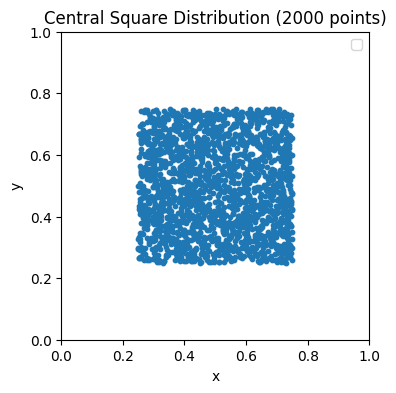

In [11]:
N_points = 2000 # From paper

np.random.seed(0)

x = np.random.uniform(low=0.25, high=0.75, size=N_points)
y = np.random.uniform(low=0.25, high=0.75, size=N_points)

# Plot the data
plt.figure(figsize=(4, 4))
plt.scatter(x, y, alpha=1, s=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Central Square Distribution (2000 points)")
plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
plt.legend()
plt.show()

In [12]:
from torch.utils.data import Dataset, DataLoader

class XYDistribution(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.stack((self.x[idx], self.y[idx]))

### Training

In [36]:
noise_size = 3
code_size = 2
beta = 0.1

net_D = Discriminator(2, 8)
net_G = Generator(noise_size + code_size, 16, 2)
net_T = T(2, code_size, 4)

batch_size = 40

dataset = XYDistribution(x, y)
dataloader = DataLoader(dataset, batch_size=batch_size)

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, noise_size + code_size)

lr = 1e-4
optimizer_D = optim.Adam(net_D.parameters(), lr=1e-3)
optimizer_G = optim.Adam(net_G.parameters(), lr=lr)
optimizer_T = optim.Adam(net_T.parameters(), lr=lr)
    

In [52]:
d_error = []
g_error = []
t_error = []
fk_prog = []

for _ in range(250):
    for batch in dataloader:
        # First Update Discriminator with batch of Real Data
        d_loss = net_D.fit_discriminator(batch, criterion, net_G, optimizer_D, noise_size+code_size)
        g_loss = net_G.fit_generator(net_D, net_T, batch_size, noise_size+code_size, criterion, optimizer_G, code_size, beta)
        t_loss = net_T.fit_t(net_G, batch_size, noise_size+code_size, code_size, optimizer_T)

        d_error.append(d_loss)
        g_error.append(g_loss)
        t_error.append(t_loss)

    print("Discriminator Loss: ", d_loss, "Generator Loss: ", g_loss, "MINE Network T Loss: ", t_loss)

    with torch.no_grad():
        fake = net_G(fixed_noise)
        fk_prog.append(fake)

Discriminator Loss:  1.391027569770813 Generator Loss:  0.4323979914188385 MINE Network T Loss:  -3.369039535522461
Discriminator Loss:  1.393385648727417 Generator Loss:  0.36722689867019653 MINE Network T Loss:  -3.0400943756103516
Discriminator Loss:  1.3822026252746582 Generator Loss:  0.4277581572532654 MINE Network T Loss:  -2.154850959777832
Discriminator Loss:  1.3837534189224243 Generator Loss:  0.48112255334854126 MINE Network T Loss:  -3.7776784896850586
Discriminator Loss:  1.392744779586792 Generator Loss:  0.5034366250038147 MINE Network T Loss:  -2.1263513565063477
Discriminator Loss:  1.3951373100280762 Generator Loss:  0.46034929156303406 MINE Network T Loss:  -2.3129825592041016
Discriminator Loss:  1.374467134475708 Generator Loss:  0.4922042191028595 MINE Network T Loss:  -2.3637866973876953
Discriminator Loss:  1.3955175876617432 Generator Loss:  0.4087557792663574 MINE Network T Loss:  -2.7143211364746094
Discriminator Loss:  1.3864327669143677 Generator Loss:  0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


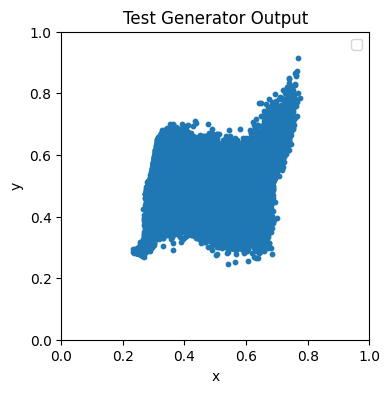

In [53]:
gen_output = net_G(torch.randn((50000, noise_size+code_size)))

x_test = gen_output[:, 0].detach().numpy()
y_test = gen_output[:, 1].detach().numpy()


# Plot test data
def plot_xy(x_pts, y_pts):
    plt.figure(figsize=(4, 4))
    plt.scatter(x_test, y_test, alpha=1, s=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Test Generator Output")
    plt.gca().set_aspect('equal', adjustable='box')  # Make the plot square
    plt.legend()
    plt.show()

plot_xy(x_test, y_test)